# Player Case Study — Anshul Sethi

## Objective
Analyse Anshul Sethi’s batting performance across recent seasons to identify
high-impact phases of the innings and opportunities to improve consistency.

## Scope
- Batting analysis only
- All formats combined (T20, one-day, multi-day)
- Directional insights due to limited sample size

## Data Preparation

In [1]:
import glob
import pandas as pd

files = sorted(glob.glob("../data/raw/Anshul Sethi Batting/*.csv"))

dfs = []
for path in files:
    temp = pd.read_csv(path)
    temp.columns = temp.columns.str.lower().str.strip()
    temp["season"] = path.split("_")[-1].replace(".csv", "")
    dfs.append(temp)

df = pd.concat(dfs, ignore_index=True)
df = df[df["balls faced"] > 0].copy()
df.shape

PLAYER_TEAMS = ["Port Adelaide", "Marion A2" , "Marion (1)" , "Marion (2)"]

In [2]:
def is_player_team(team):
    return any(alias.lower() in team.lower() for alias in PLAYER_TEAMS)

df["home_is_player_team"] = df["home team"].apply(is_player_team)
df["away_is_player_team"] = df["away team"].apply(is_player_team)

In [3]:
df["opponent"] = df.apply(
    lambda x: x["away team"] if x["home_is_player_team"] else x["home team"],
    axis=1
)

In [4]:
df["good_score"] = (df["runs scored"] >= 30).astype(int)

In [5]:
bins_balls = [0, 5, 10, 15, 20, 30, 1000]
labels_balls = ["0–5", "6–10", "11–15", "16–20", "21–30", "30+"]

df["balls_bucket"] = pd.cut(df["balls faced"], bins=bins_balls, labels=labels_balls)

In [6]:
bins_runs = [0, 10, 20, 40, 200]
labels_runs = ["0–9", "10–19", "20–39", "40+"]

df["runs_bucket"] = pd.cut(df["runs scored"], bins=bins_runs, labels=labels_runs)

In [7]:
df["boundary_runs"] = df["4s scored"] * 4 + df["6s scored"] * 6
df["boundary_pct"] = df["boundary_runs"] / df["runs scored"] 
df.loc[df["runs scored"] == 0, "boundary_pct"] = 0
df["dismissed"] = ~df["how out"].str.contains(
    "Not Out|did not bat", case=False, na=False
)

In [8]:
df["phase"] = df["balls faced"].apply(
    lambda x: "Set (30+)" if x > 30 else "Early (<30)"
)

## Average runs scored and the probability of scoring 30+ by number of balls faced

In [9]:
bucket_summary = (
    df.groupby("balls_bucket")
      .agg(
          innings=("runs scored", "count"),
          avg_runs=("runs scored", "mean"),
          good_score_rate=("good_score", "mean")
      )
      .reset_index()
)

bucket_summary

,balls_bucket,innings,avg_runs,good_score_rate
0,0–5,10,0.700000,0.000000
1,6–10,4,2.500000,0.000000
2,11–15,3,11.000000,0.000000
3,16–20,4,10.750000,0.000000
4,21–30,9,8.333333,0.000000
5,30+,22,47.545455,0.772727


In [10]:
phase_summary = (
    df.groupby("phase")
      .agg(
          innings=("runs scored", "count"),
          avg_runs=("runs scored", "mean"),
          good_score_rate=("good_score", "mean")
      )
      .reset_index()
)

phase_summary

,phase,innings,avg_runs,good_score_rate
0,Early (<30),30,5.600000,0.000000
1,Set (30+),22,47.545455,0.772727


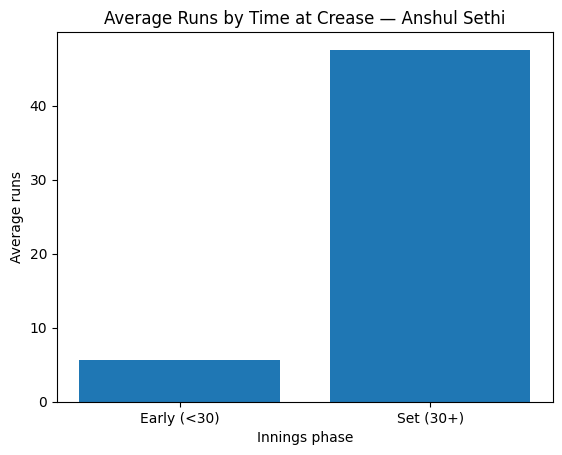

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(
    phase_summary["phase"],
    phase_summary["avg_runs"]
)
plt.ylabel("Average runs")
plt.xlabel("Innings phase")
plt.title("Average Runs by Time at Crease — Anshul Sethi")
plt.show()

## Dismissal types by number of balls faced

In [12]:
dismissed_df = df[
    ~df["how out"].str.contains("Not Out|did not bat", case=False, na=False)
].copy()

counts = dismissed_df.groupby(["balls_bucket", "how out"]).size()
proportions = counts / counts.groupby(level=0).sum()

dismissal_by_bucket = proportions.reset_index(name="proportion")
dismissal_by_bucket

,balls_bucket,how out,proportion
0,0–5,Bowled,0.300000
1,0–5,Caught,0.300000
2,0–5,LBW,0.400000
3,6–10,Bowled,0.250000
4,6–10,Caught,0.500000
5,6–10,LBW,0.250000
6,11–15,Caught,0.500000
7,11–15,LBW,0.500000
8,16–20,Bowled,0.666667
9,16–20,Caught,0.333333


In [13]:
dismissal_pivot = dismissal_by_bucket.pivot(
    index="balls_bucket",
    columns="how out",
    values="proportion"
).fillna(0)

dismissal_pivot

how out,Bowled,Caught,LBW,Run Out
balls_bucket,,,,
0–5,0.300000,0.300000,0.400,0.000000
6–10,0.250000,0.500000,0.250,0.000000
11–15,0.000000,0.500000,0.500,0.000000
16–20,0.666667,0.333333,0.000,0.000000
21–30,0.250000,0.625000,0.125,0.000000
30+,0.333333,0.611111,0.000,0.055556


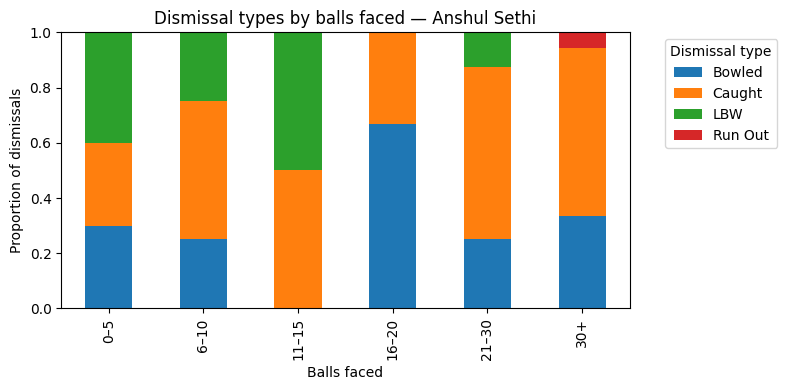

In [14]:
import matplotlib.pyplot as plt

dismissal_pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 4)
)
plt.ylabel("Proportion of dismissals")
plt.xlabel("Balls faced")
plt.title("Dismissal types by balls faced — Anshul Sethi")
plt.legend(title="Dismissal type", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

## Conversion Rate: 30+ to 50+

In [15]:
starts_30 = df[df["runs scored"] >= 30]
conversion_rate = (starts_30["runs scored"] >= 50).mean()
print(conversion_rate)

0.47058823529411764


## Dismissal types by number of runs scored

In [16]:
counts = dismissed_df.groupby(["runs_bucket", "how out"]).size()
proportions = counts / counts.groupby(level=0).sum()

dismissal_by_runs = proportions.reset_index(name="proportion")
dismissal_by_runs

,runs_bucket,how out,proportion
0,0–9,Bowled,0.235294
1,0–9,Caught,0.529412
2,0–9,LBW,0.235294
3,10–19,Bowled,0.750000
4,10–19,Caught,0.250000
5,20–39,Bowled,0.333333
6,20–39,Caught,0.666667
7,40+,Bowled,0.200000
8,40+,Caught,0.700000
9,40+,Run Out,0.100000


In [17]:
dismissal_runs_pivot = dismissal_by_runs.pivot(
    index="runs_bucket",
    columns="how out",
    values="proportion"
).fillna(0)

dismissal_runs_pivot

how out,Bowled,Caught,LBW,Run Out
runs_bucket,,,,
0–9,0.235294,0.529412,0.235294,0.0
10–19,0.750000,0.250000,0.000000,0.0
20–39,0.333333,0.666667,0.000000,0.0
40+,0.200000,0.700000,0.000000,0.1


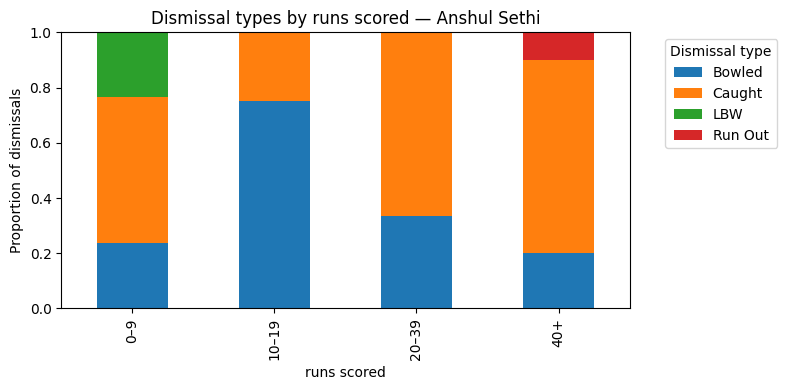

In [18]:
import matplotlib.pyplot as plt

dismissal_runs_pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 4)
)
plt.ylabel("Proportion of dismissals")
plt.xlabel("runs scored")
plt.title("Dismissal types by runs scored — Anshul Sethi")
plt.legend(title="Dismissal type", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

## Key Takeaways
- Time at the crease is the primary driver of higher scores
- Once past key milestones, Anshul converts starts efficiently
- Early dismissals are more technical; later dismissals are intent-driven
